In [3]:
pip install osmnx geopandas requests descartes contextily tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from tqdm.auto import tqdm
import shapely.speedups
shapely.speedups.enable() 
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import PathPatch
from matplotlib.path import Path

/Users/claudiacortese/charging_stations/charging_stations/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2715854114.py:11: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


In [5]:
PLACE_NAME = 'Catania, Italy'
name = 'Catania'
grid_size = 500

epsg:4326
EPSG:32633


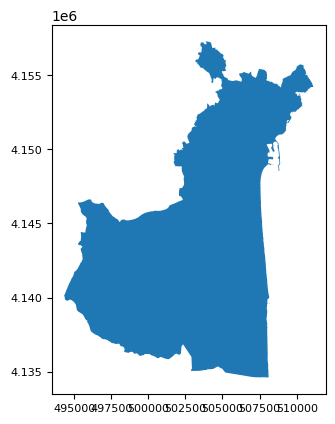

<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [6]:
city = ox.geocode_to_gdf(PLACE_NAME)
print(city.crs)
# changing CRS for grid division
city = ox.project_gdf(city) 
print(city.crs)

# Plot and store the axis object
ax = city.plot()

# Customize the font size of the tick labels on the axes
ax.tick_params(axis='both', which='major', labelsize=8)

# Display the plot
plt.show()

# Print the type of geometry for your information
geometry = city['geometry'].iloc[0]
print(type(geometry))

In [8]:
#save geometry
city.to_file(f"/Users/claudiacortese/Desktop/{name}.shp")

Division into grid

In [9]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=grid_size) #500 Meter grid
print(type(geometry_cut))
polylist = [poly for poly in geometry_cut.geoms]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


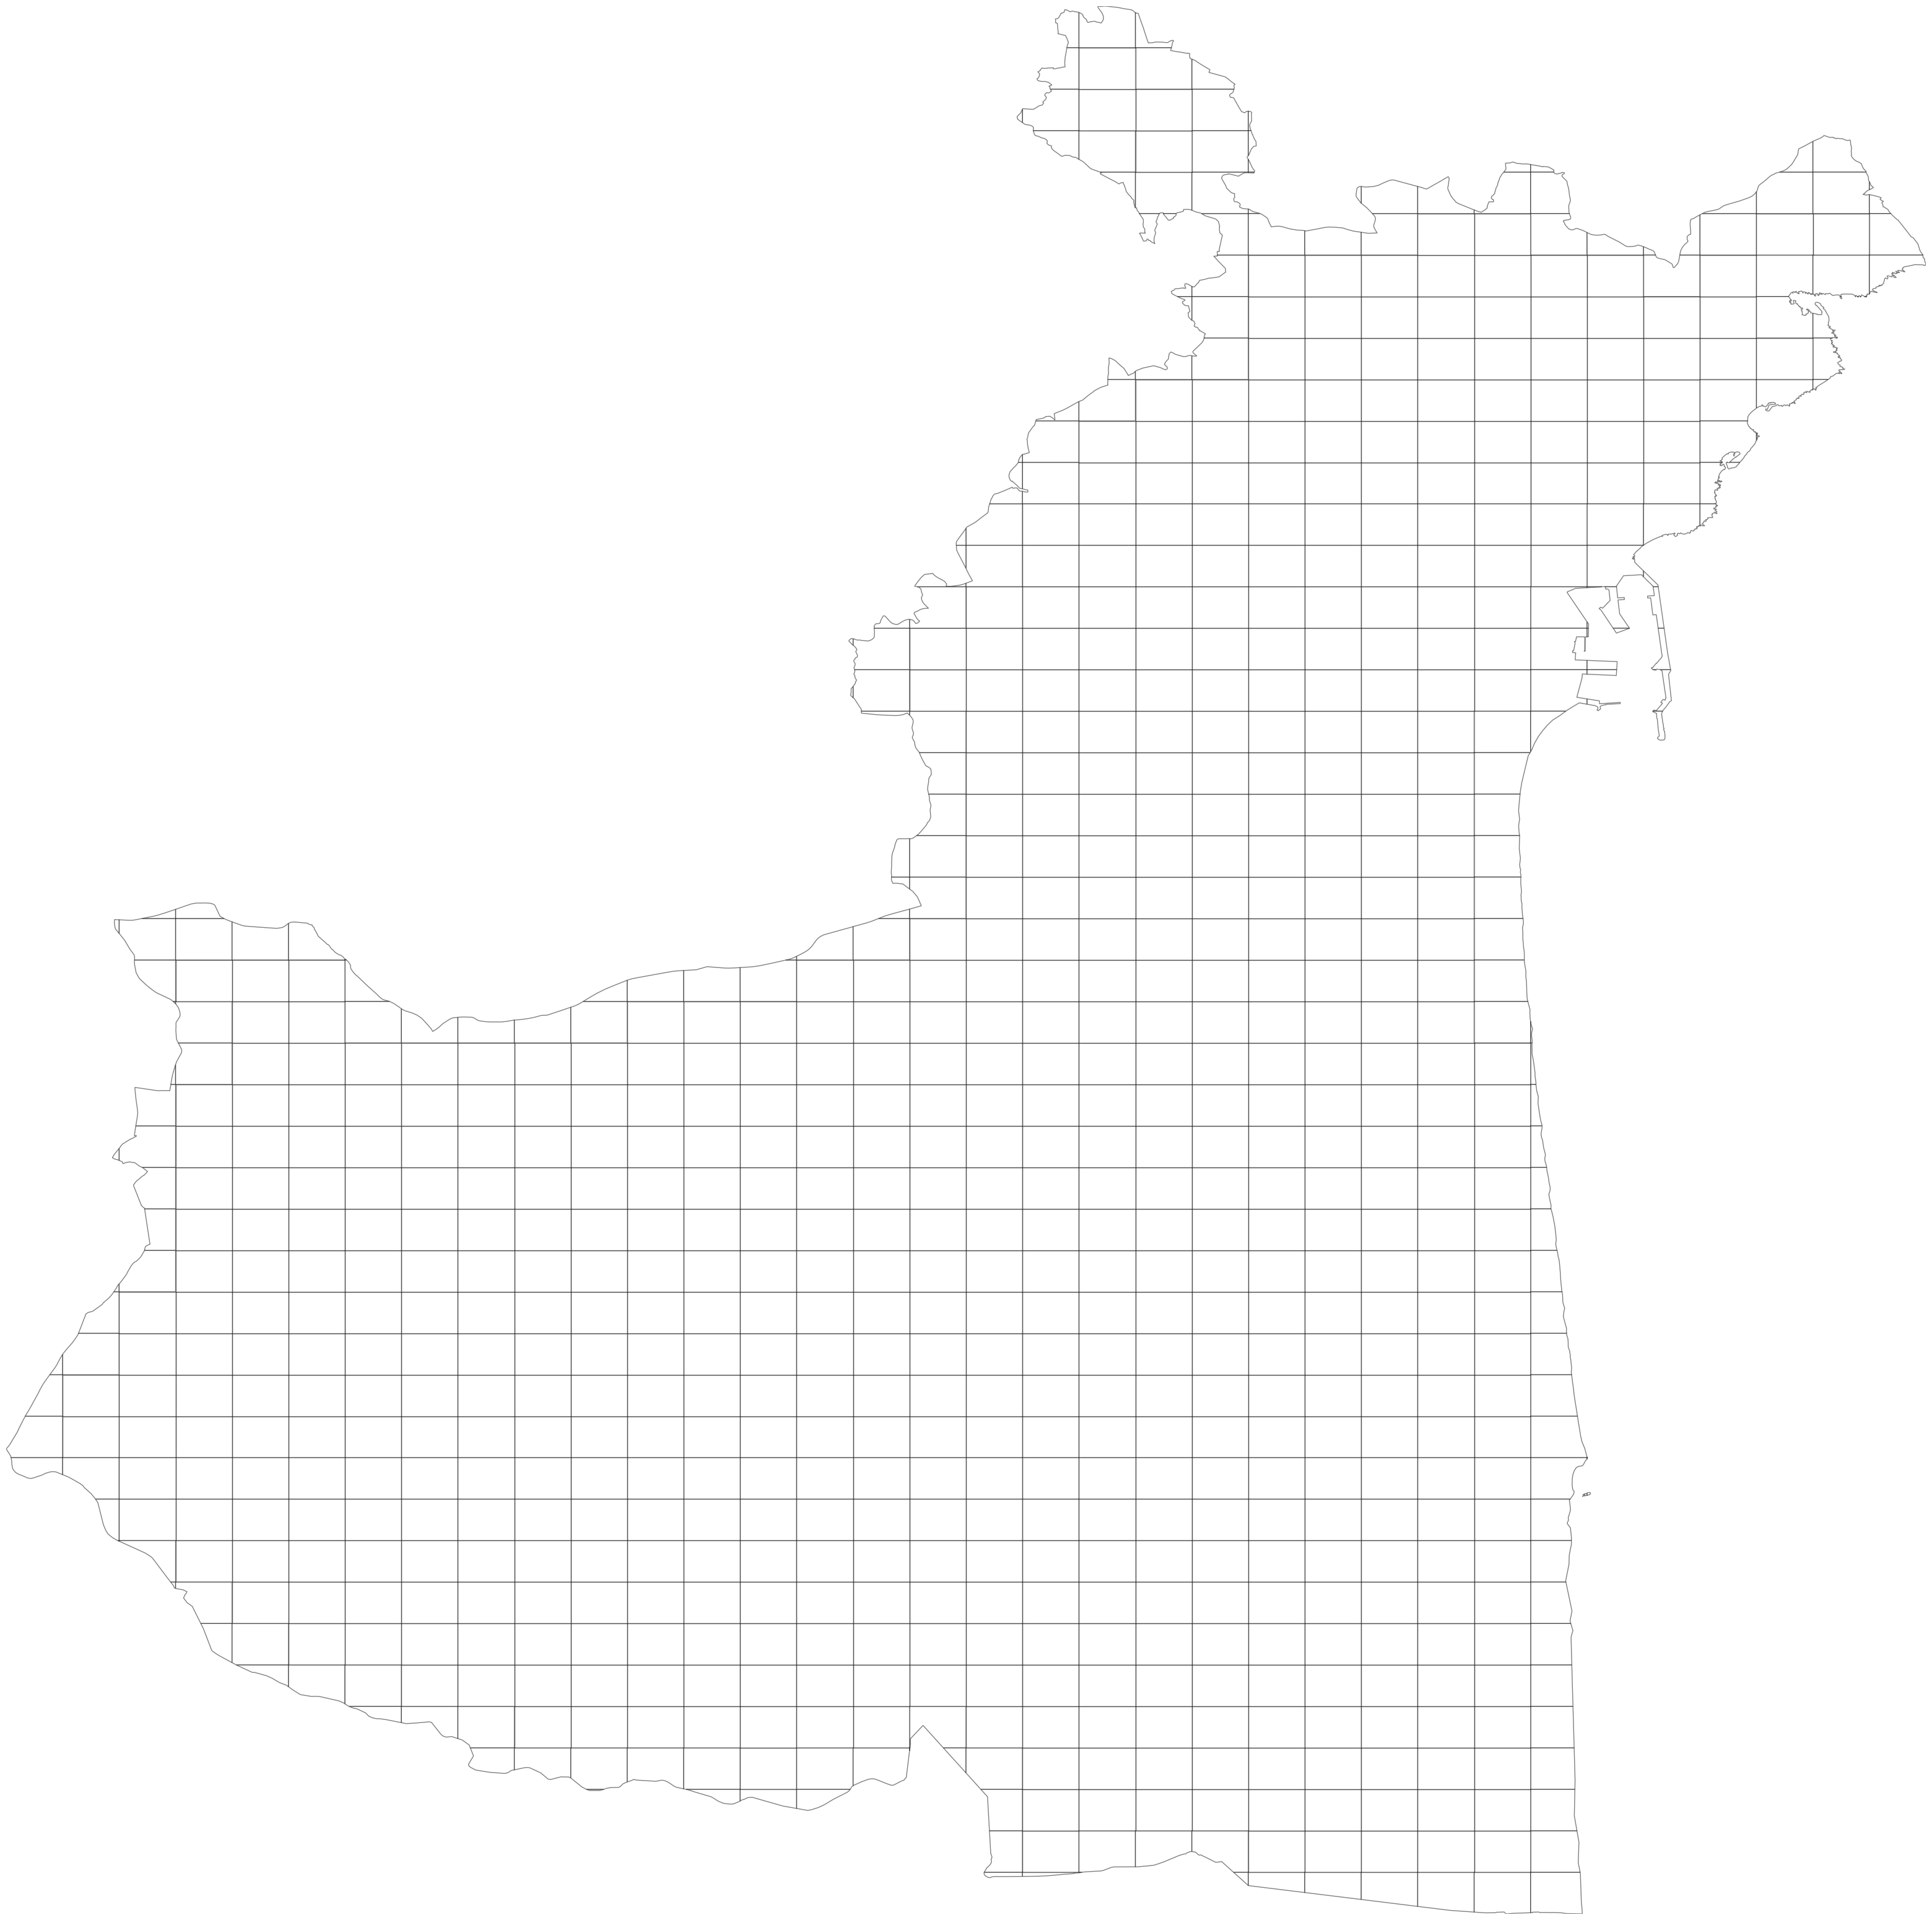

In [10]:
import shapely.geometry as sg
polylist = [poly for poly in geometry_cut.geoms]
# plot city
west, south, east, north = city.unary_union.bounds

# Manual patch creation
fig, ax = plt.subplots(figsize=(40, 40))
for polygon in geometry_cut.geoms:
    if isinstance(polygon, sg.Polygon) and not polygon.is_empty:
        verts = np.array(polygon.exterior.coords)
        codes = np.full(len(verts), Path.LINETO)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='white', edgecolor='black', alpha=0.5)
        ax.add_patch(patch)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [11]:
city_polyframe = gpd.GeoDataFrame(geometry=polylist)
city_polyframe.crs = city.crs
print(city_polyframe.crs)
city_polyframe.head()

EPSG:32633


geometry
0  POLYGON ((494324.369 4140139.901, 494346.085 4...
1  POLYGON ((494491.378 4140530.023, 494493.290 4...
2  POLYGON ((494705.809 4141022.186, 494724.679 4...
3  POLYGON ((494818.176 4140037.860, 494818.176 4...
4  POLYGON ((494818.176 4141263.137, 494829.130 4...

(4489167.15217198, 4517788.7544710105)

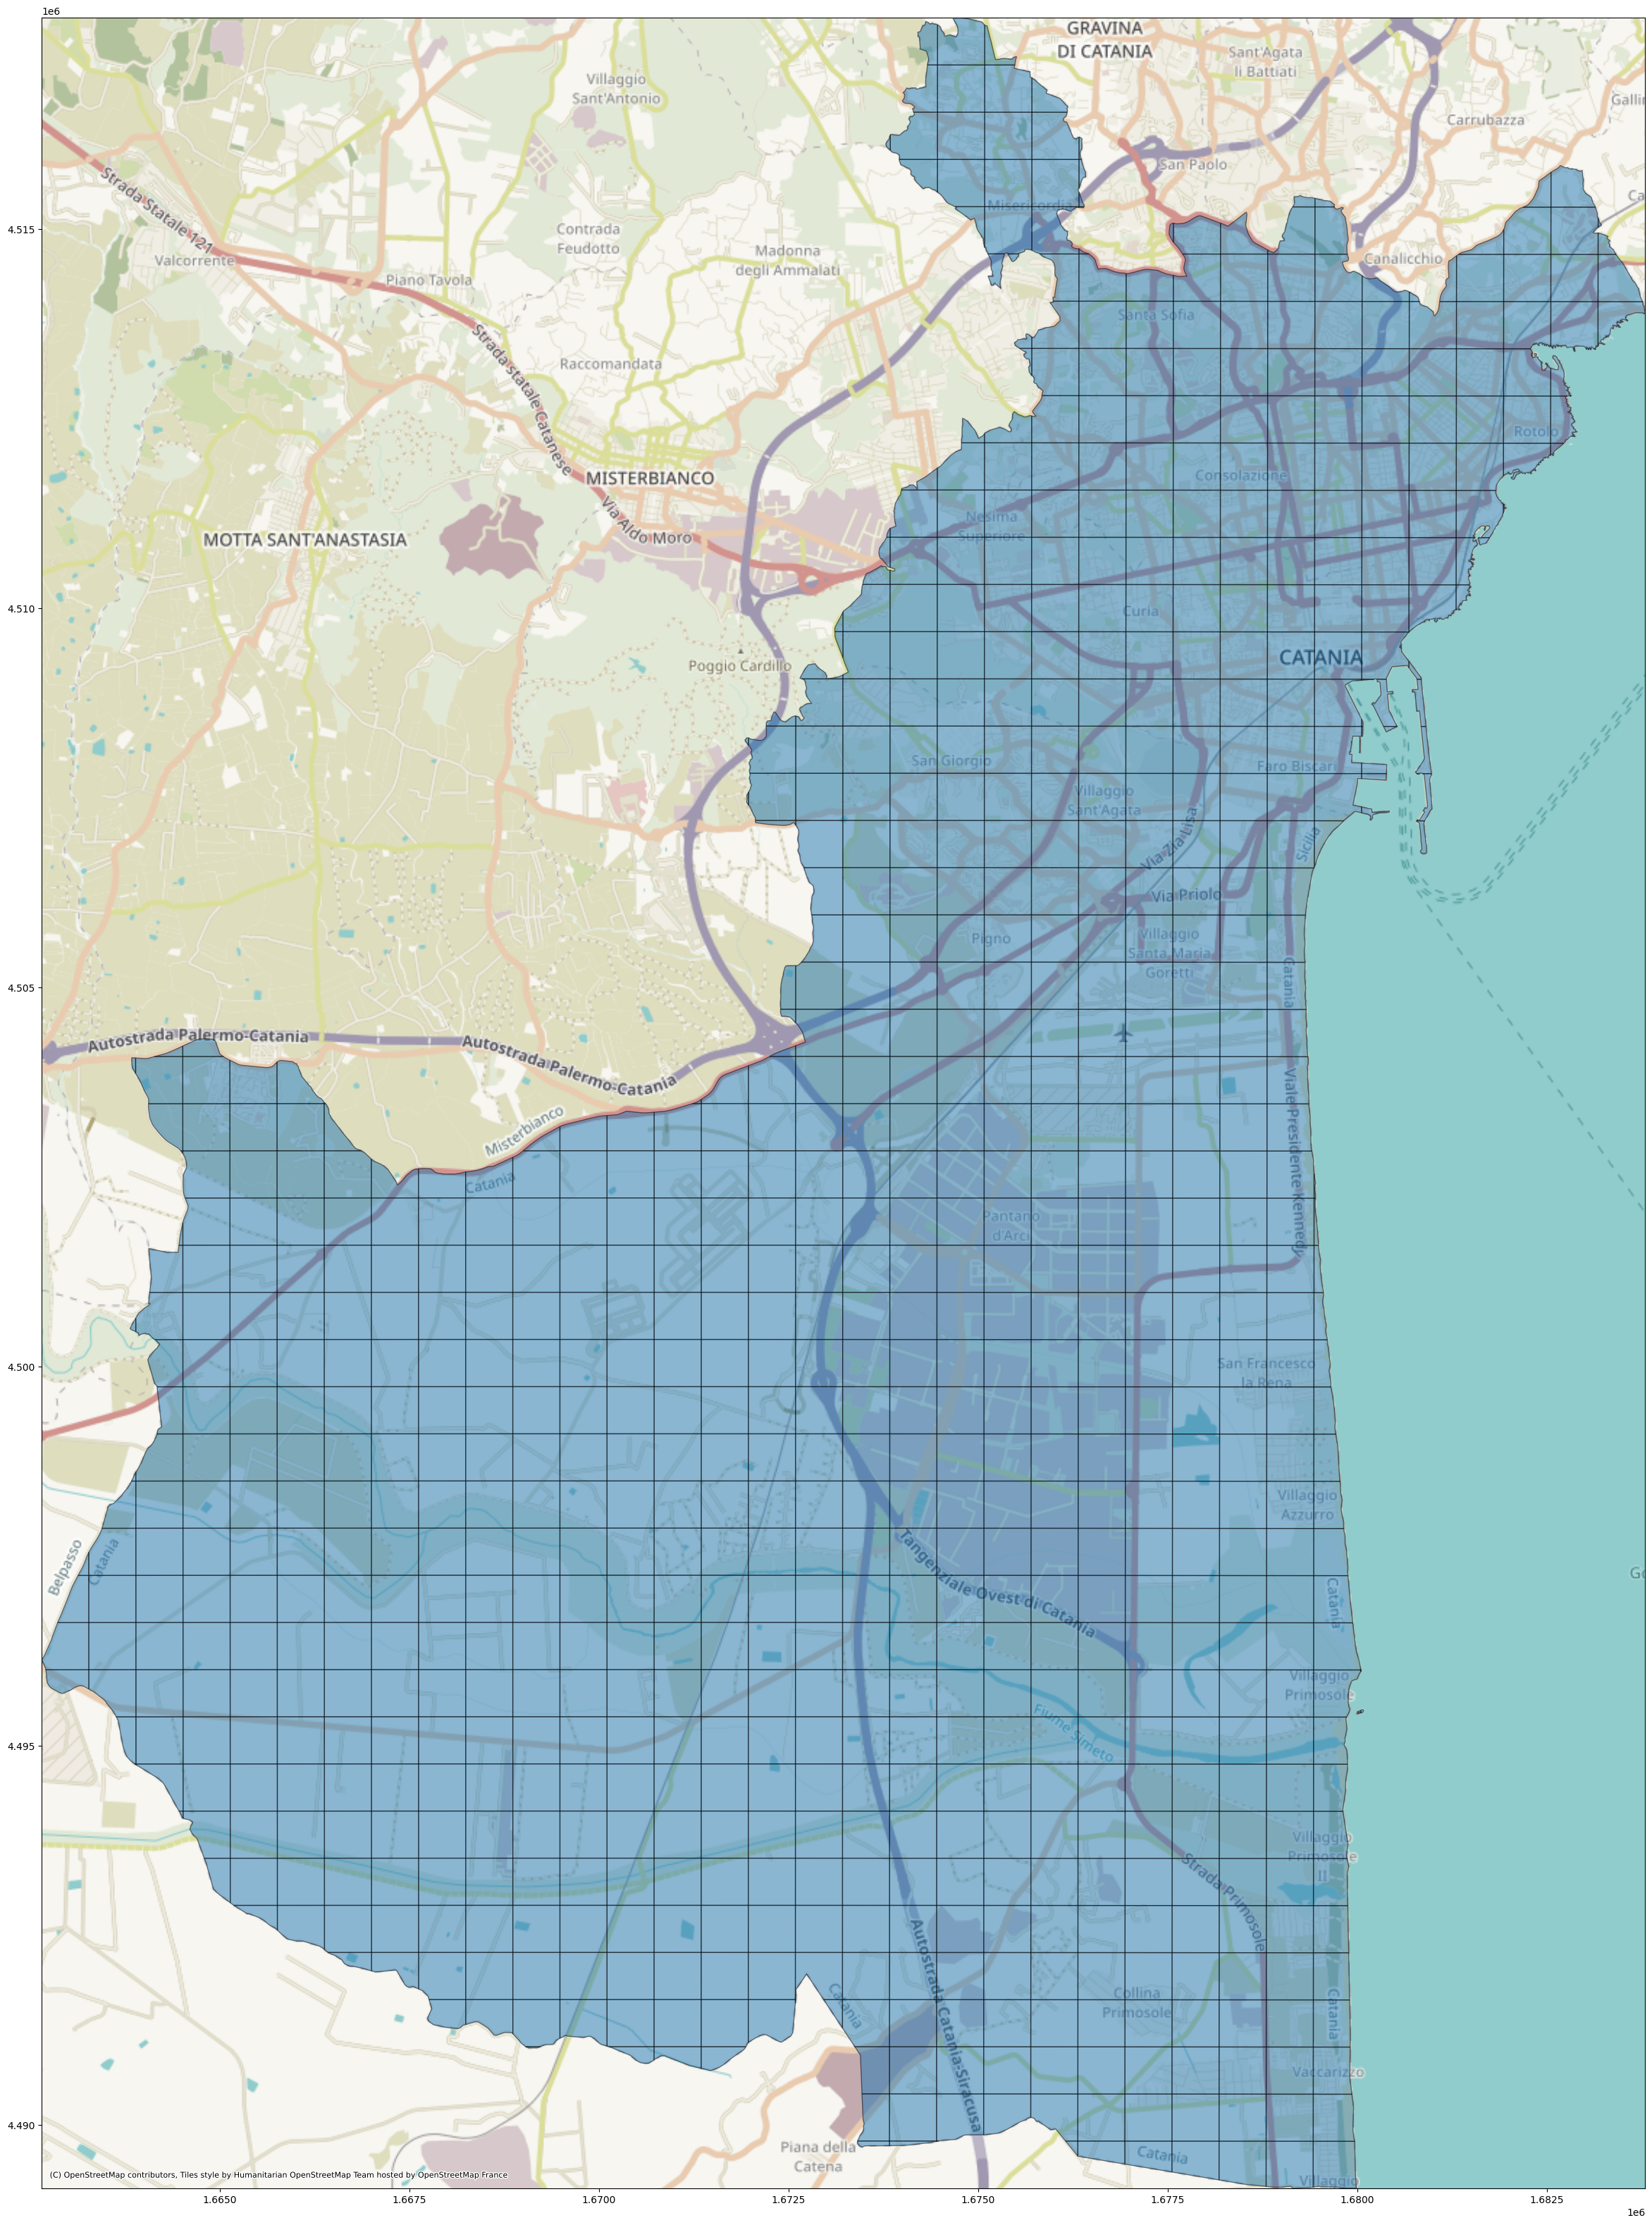

In [12]:
import contextily as ctx
# ctx uses epsg:3857ax = city.plot()
polyframe_3857 = city_polyframe.to_crs(epsg=3857)
west, south, east, north = polyframe_3857.unary_union.bounds

ax = polyframe_3857.plot(figsize=(40,40), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=13)
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# POIs

In [13]:
city_polyframe_lat_long = ox.project_gdf(city_polyframe, to_latlong=True) #Changing CRS to (Lat, long)
city_polyframe_lat_long.head()

geometry
0  POLYGON ((14.93587 37.40803, 14.93611 37.40836...
1  POLYGON ((14.93775 37.41155, 14.93777 37.41159...
2  POLYGON ((14.94017 37.41598, 14.94038 37.41630...
3  POLYGON ((14.94145 37.40711, 14.94145 37.40529...
4  POLYGON ((14.94144 37.41816, 14.94156 37.41835...

# EV Stations

In [14]:
EV_stations = ox.geometries_from_place(
    PLACE_NAME,
    {"amenity": "charging_station"},
)

In [15]:
EV_stations.head()

amenity        name    operator  \
element_type osmid                                                  
node         6704288555  charging_station  Enel X Way  Enel X Way   
             6704288557  charging_station  Enel X Way  Enel X Way   
             6704288558  charging_station  Enel X Way  Enel X Way   
             6704288559  charging_station  Enel X Way  Enel X Way   
             6704288560  charging_station        Eva+        Enel   

                        operator:wikidata operator:wikipedia  \
element_type osmid                                             
node         6704288555        Q116116836      it:Enel X Way   
             6704288557        Q116116836      it:Enel X Way   
             6704288558        Q116116836      it:Enel X Way   
             6704288559        Q116116836      it:Enel X Way   
             6704288560               NaN                NaN   

                                          geometry   access capacity motorcar  \
element_type osmid                                                              
node         6704288555  POINT (15.07563 37.50854)      NaN      NaN      NaN   
             6704288557  POINT (15.08999 37.49501)  private        2      yes   
             6704288558  POINT (15.08360 37.48843)      NaN      NaN      NaN   
             6704288559  POINT (15.08354 37.48841)      NaN      NaN      NaN   
             6704288560  POINT (15.03485 37.44801)      NaN      NaN      NaN   

                         fee opening_hours brand brand:wikidata  \
element_type osmid                                                
node         6704288555  NaN           NaN   NaN            NaN   
             6704288557  NaN           NaN   NaN            NaN   
             6704288558  NaN           NaN   NaN            NaN   
             6704288559  NaN           NaN   NaN            NaN   
             6704288560  NaN           NaN   NaN            NaN   

                        payment:credit_cards  
element_type osmid                            
node         6704288555                  NaN  
             6704288557                  NaN  
             6704288558                  NaN  
             6704288559                  NaN  
             6704288560                  NaN

Text(0.5, 1.0, 'Catania EV stations')

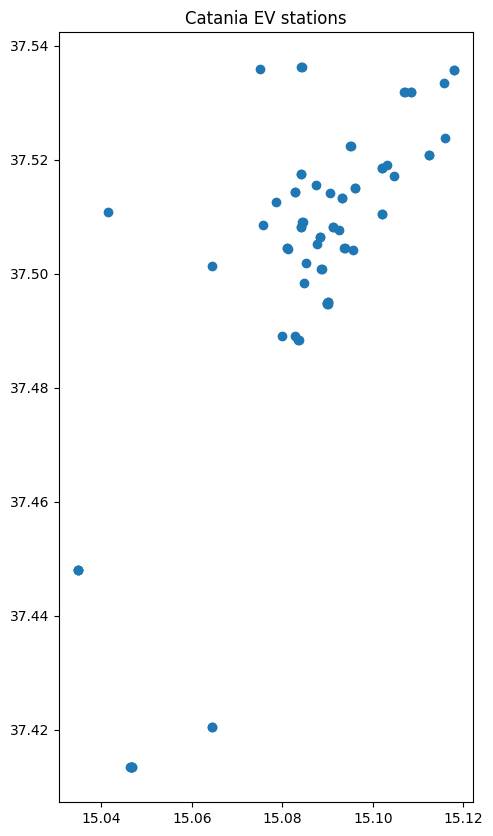

In [16]:
#plot EV stations geo data
EV_stations.plot(figsize=(10,10))
plt.title("Catania EV stations")

Text(0.5, 1.0, 'Catania EV stations')

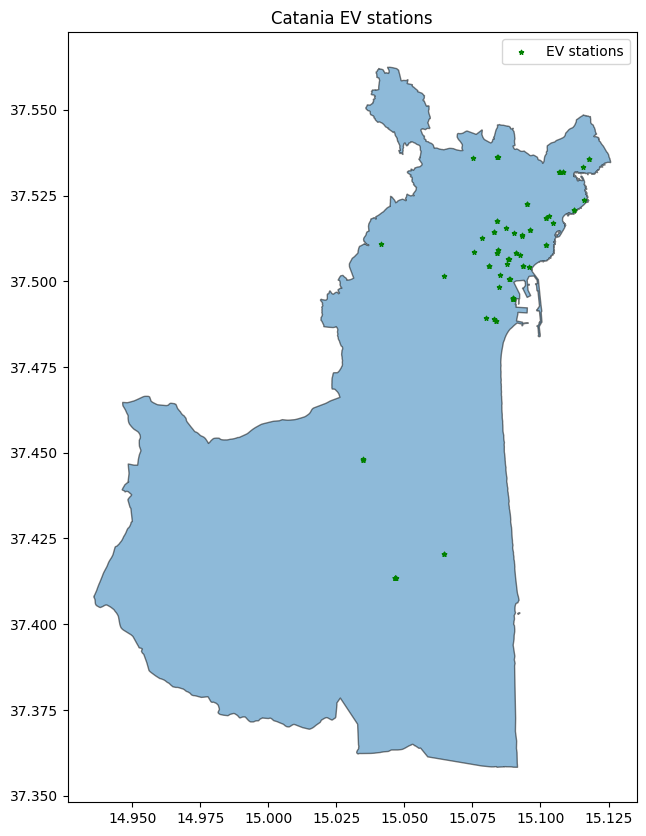

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ox.project_gdf(city, to_latlong=True).plot(ax =ax, alpha=0.5, edgecolor='k')
EV_stations.plot(ax=ax, color='green', marker='*', markersize=10)
#add legend
plt.legend(['EV stations'])
plt.title("Catania EV stations")

In [18]:
#intersection of points and polygons
import shapely.speedups
shapely.speedups.enable() 

masks_EV = []
for i in tqdm(range(0,city_polyframe.shape[0])):
    pip_mask = EV_stations.within(city_polyframe_lat_long.loc[i, 'geometry']) 
    masks_EV.append(pip_mask)

/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/3985573752.py:3: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()
100%|██████████| 872/872 [00:00<00:00, 34278.04it/s]


In [19]:
# create a new geodataframe with mask EV stations 
EV_stations_masked = gpd.GeoDataFrame()
for i in tqdm(range(0,city_polyframe.shape[0])):
    EV_stations_masked = pd.concat([EV_stations_masked, EV_stations[masks_EV[i]][['geometry']]], ignore_index=True)

100%|██████████| 872/872 [00:00<00:00, 2777.16it/s]


In [20]:
catania_polyframe_lat_long_new = city_polyframe_lat_long.copy()
catania_polyframe_lat_long_new['EV_stations_counts'] = 0
catania_polyframe_lat_long_new['EV_stations_geomery'] = 0

In [21]:
for i in tqdm(range(0,catania_polyframe_lat_long_new.shape[0])):
    catania_polyframe_lat_long_new.loc[i, 'EV_stations_counts'] = EV_stations[masks_EV[i]].shape[0]
    catania_polyframe_lat_long_new.loc[i, 'EV_stations_geomery'] = str(EV_stations[masks_EV[i]][['geometry']].values.tolist())

  0%|          | 0/872 [00:00<?, ?it/s]/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2127218185.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  catania_polyframe_lat_long_new.loc[i, 'EV_stations_geomery'] = str(EV_stations[masks_EV[i]][['geometry']].values.tolist())
100%|██████████| 872/872 [00:00<00:00, 1947.17it/s]


In [22]:
#How many EV stations in each grid
catania_polyframe_lat_long_new['EV_stations_counts'].value_counts()
#Percentage of EV stations in each grid
catania_polyframe_lat_long_new['EV_stations_counts'].value_counts() / catania_polyframe_lat_long_new.shape[0]

EV_stations_counts
0    0.963303
1    0.013761
2    0.009174
3    0.005734
4    0.004587
6    0.002294
5    0.001147
Name: count, dtype: float64

In [23]:
catania_polyframe_lat_long_new.head(5)

geometry  EV_stations_counts  \
0  POLYGON ((14.93587 37.40803, 14.93611 37.40836...                   0   
1  POLYGON ((14.93775 37.41155, 14.93777 37.41159...                   0   
2  POLYGON ((14.94017 37.41598, 14.94038 37.41630...                   0   
3  POLYGON ((14.94145 37.40711, 14.94145 37.40529...                   0   
4  POLYGON ((14.94144 37.41816, 14.94156 37.41835...                   0   

  EV_stations_geomery  
0                  []  
1                  []  
2                  []  
3                  []  
4                  []

## Population data visualize and add to each grid

In [24]:
df_pop = pd.read_csv("/Users/claudiacortese/Desktop/ita_general_2020.csv")
gdf = gpd.GeoDataFrame(df_pop, geometry=gpd.points_from_xy(df_pop.longitude, df_pop.latitude))

In [25]:
df_pop.head()

longitude   latitude  ita_general_2020
0   6.215694  48.000139          1.061017
1   6.216250  48.000139          1.061017
2   6.216528  48.000139          1.061017
3   6.243750  48.000139          0.831058
4   6.244028  48.000139          0.831058

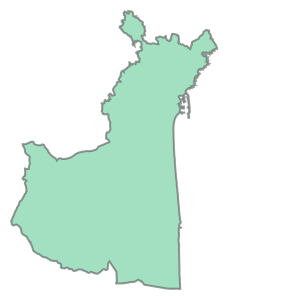

In [26]:
#extract population data for Catania
city.geometry[0]

In [27]:
# change crs to lat long
city_lat_long = ox.project_gdf(city, to_latlong=True)
pip_mask = gdf.within(city_lat_long.loc[0, 'geometry'])

In [28]:
catania_pop_gdf = gdf.loc[pip_mask]

<Axes: >

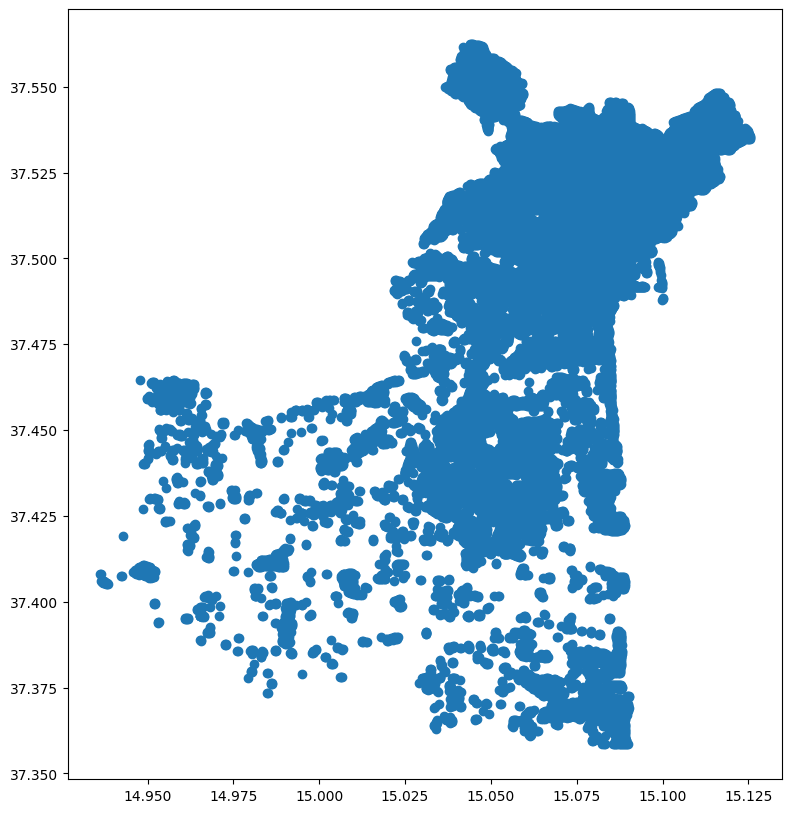

In [29]:
#plot population data with cmap
catania_pop_gdf.plot(figsize=(10,10))

In [30]:
catania_pop_gdf.to_csv(f"/Users/claudiacortese/Desktop/{name}-population.csv")

In [31]:
# population for each grid
masks_pop = []
for i in tqdm(range(0,city_polyframe_lat_long.shape[0])):
    pip_mask = catania_pop_gdf.within(city_polyframe_lat_long.loc[i, 'geometry'])
    masks_pop.append(pip_mask)

100%|██████████| 872/872 [00:01<00:00, 834.49it/s] 


In [32]:
pop_grid = []
for i in range(0,city_polyframe_lat_long.shape[0]):
    pop_grid.append(catania_pop_gdf.loc[masks_pop[i]].ita_general_2020.mean())

In [33]:
pop_grid = np.nan_to_num(pop_grid)

In [34]:
catania_polyframe_lat_long_new['population'] = pop_grid
catania_polyframe_lat_long_new.head()

geometry  EV_stations_counts  \
0  POLYGON ((14.93587 37.40803, 14.93611 37.40836...                   0   
1  POLYGON ((14.93775 37.41155, 14.93777 37.41159...                   0   
2  POLYGON ((14.94017 37.41598, 14.94038 37.41630...                   0   
3  POLYGON ((14.94145 37.40711, 14.94145 37.40529...                   0   
4  POLYGON ((14.94144 37.41816, 14.94156 37.41835...                   0   

  EV_stations_geomery  population  
0                  []         0.0  
1                  []         0.0  
2                  []         0.0  
3                  []         0.0  
4                  []         0.0

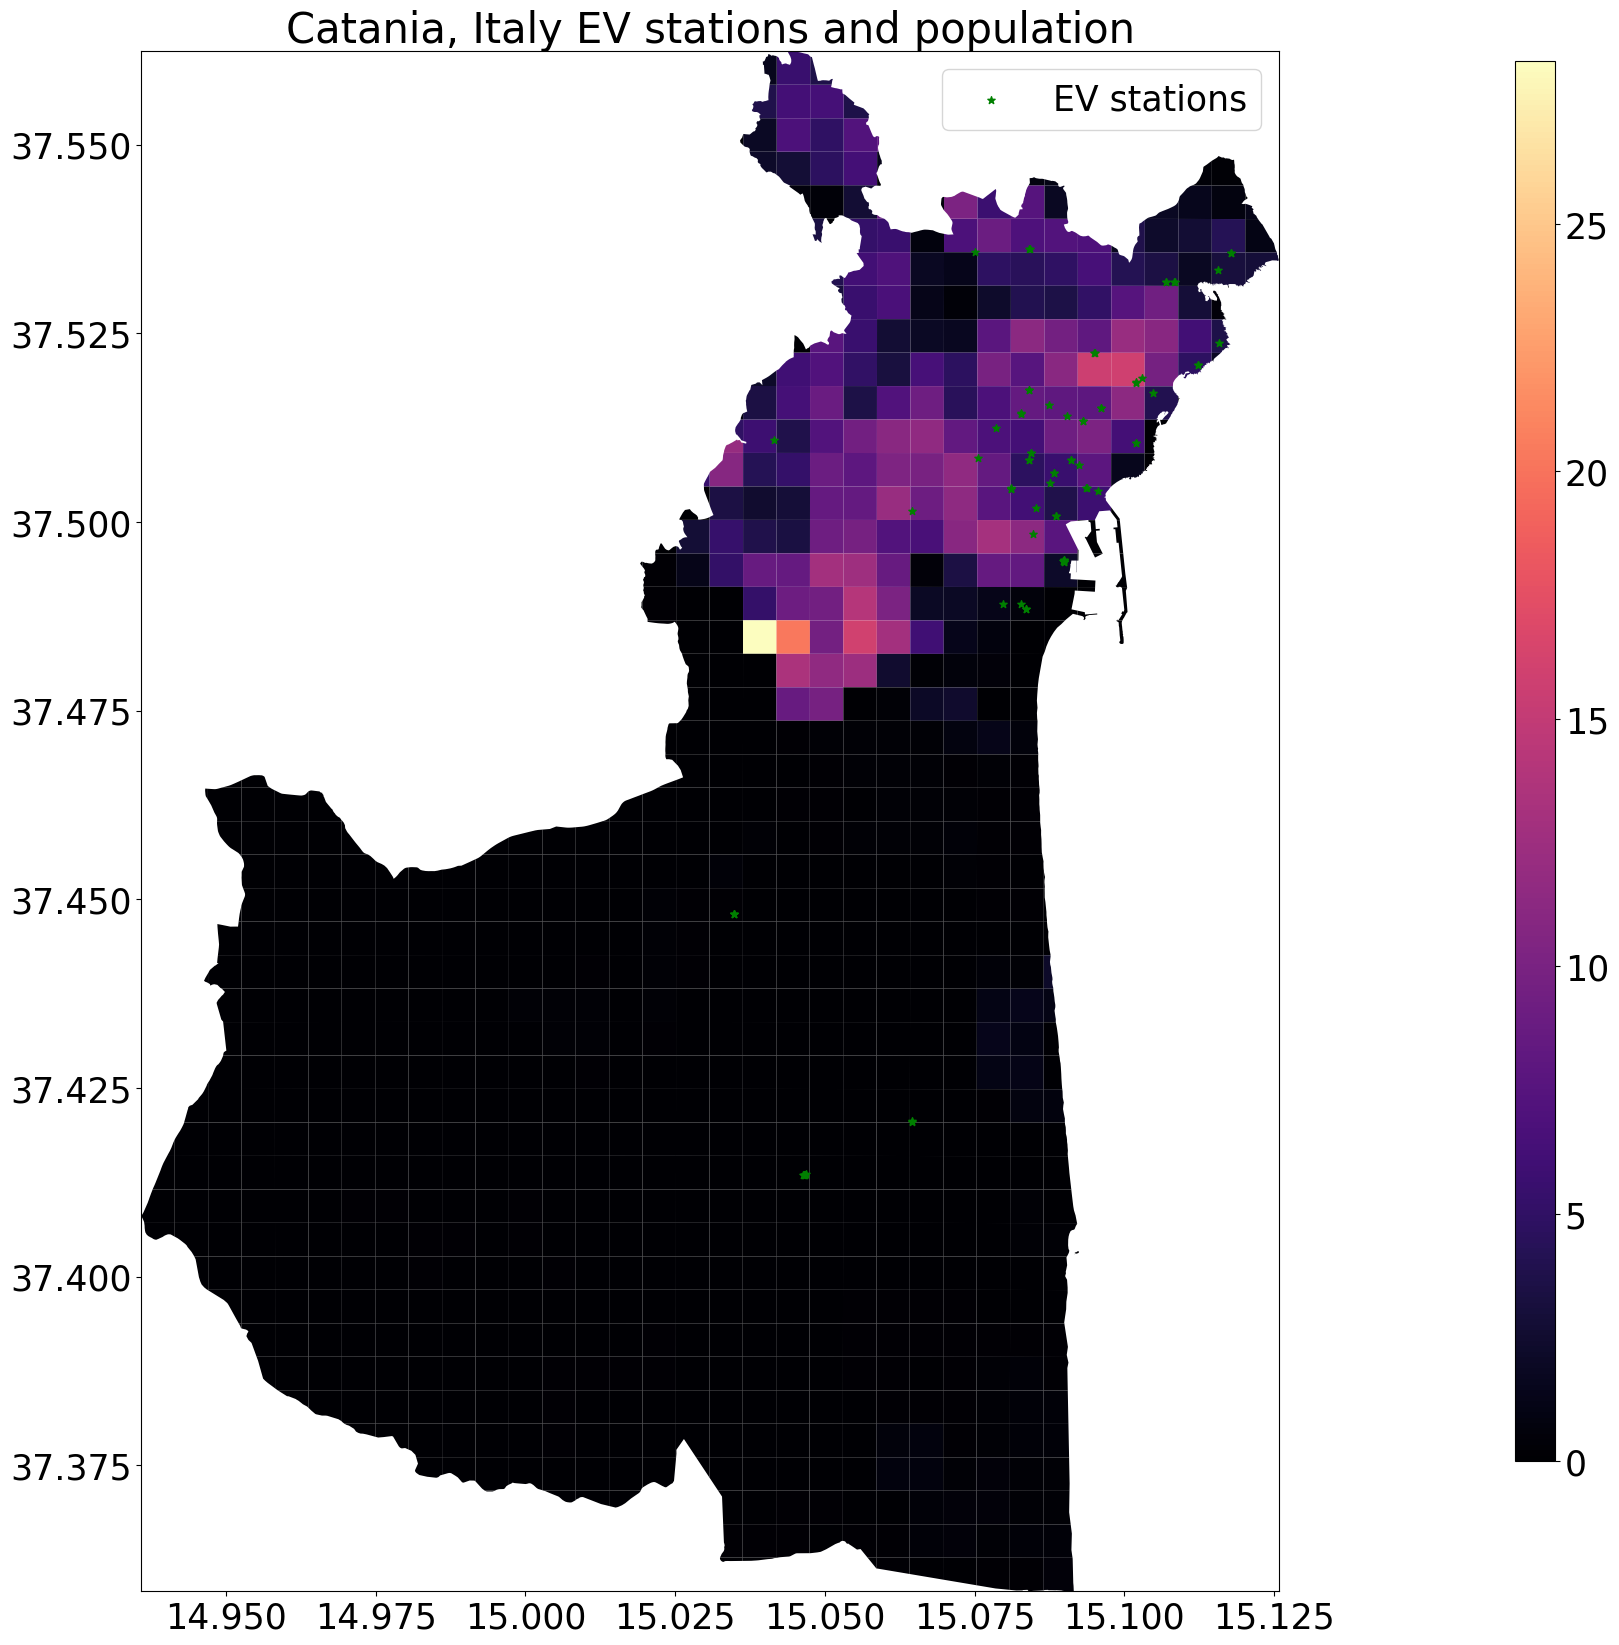

In [35]:
plt.rcParams.update({'font.size':25})
west, south, east, north = catania_polyframe_lat_long_new.unary_union.bounds

fig, ax = plt.subplots(figsize=(20,20))
catania_polyframe_lat_long_new.plot(ax=ax, column = 'population', legend=False, cmap='magma')
# add EV stations
EV_stations.plot(ax=ax, color='green', markersize=30, marker='*', label='EV stations')
# add legend
plt.legend(['EV stations'])
plt.title(f'{PLACE_NAME} EV stations and population')
cbax = fig.add_axes([0.915, 0.175, 0.02, 0.7])

sm = plt.cm.ScalarMappable(cmap='magma', \
                          norm = plt.Normalize(vmin=min(catania_polyframe_lat_long_new.population), vmax=max(catania_polyframe_lat_long_new.population)))
sm._A = []
# draw colormap into cbax
fig.colorbar(sm, cax=cbax, format="%d")
ax.set_xlim(west, east)
ax.set_ylim(south, north)
# ax.axis('off')30
plt.show()

# Land use

In [36]:
landuse = ox.geometries_from_place(PLACE_NAME, tags={'landuse': True})

# Define the categories
categories = {
    'residential': ['residential'],
    'commercial': ['commercial', 'retail', 'office', 'industrial'],
    'retail': ['retail'],
    'industrial': ['industrial']
}

# Create a new column to categorize the landuse types
landuse['category'] = 'Other'

# Iterate through the categories and assign the corresponding landuse types
for category, tags in categories.items():
    landuse.loc[landuse['landuse'].isin(tags), 'category'] = category

/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/4238397865.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse = ox.geometries_from_place(PLACE_NAME, tags={'landuse': True})


In [37]:
landuse.to_csv(f"/Users/claudiacortese/Desktop/{name}-landuse.csv")

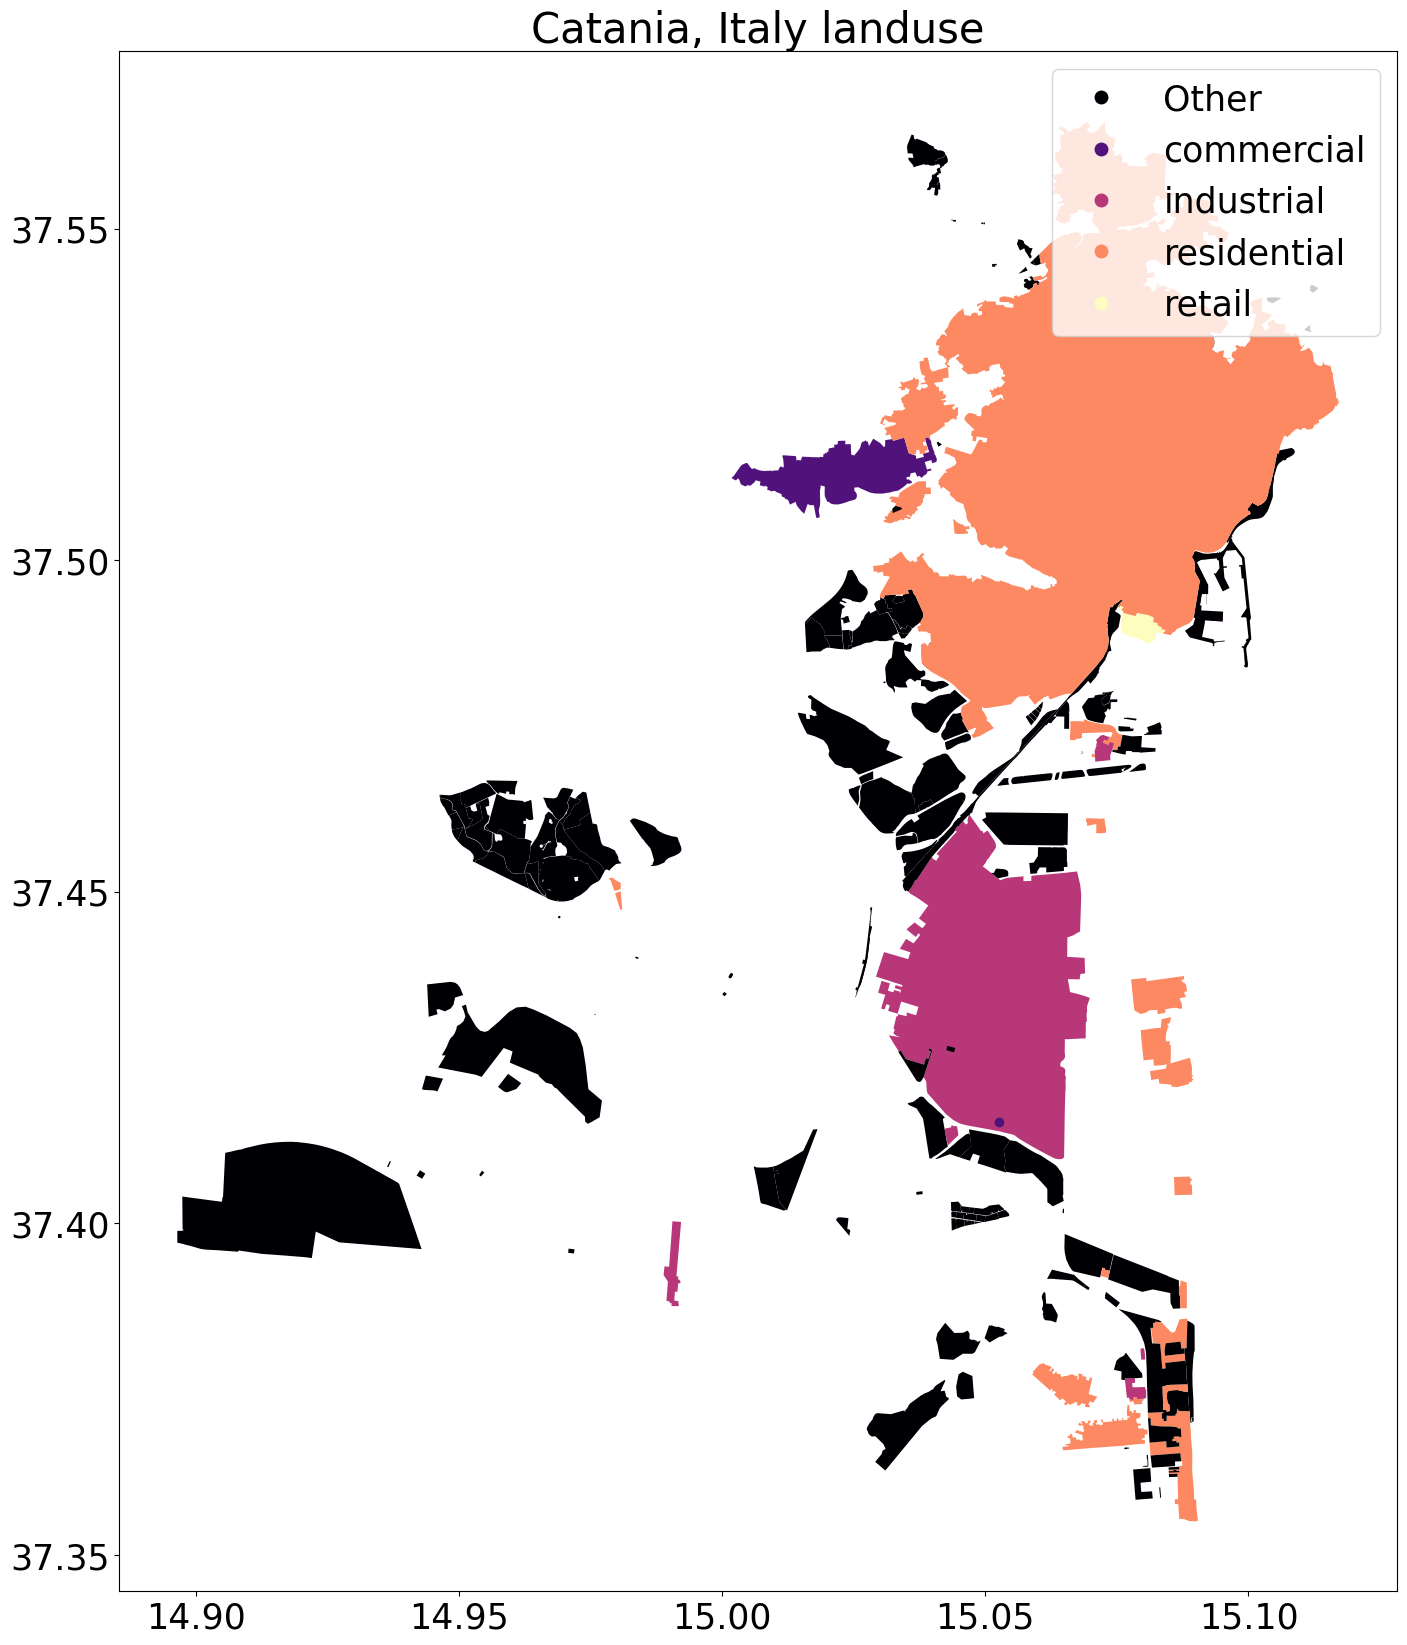

In [38]:
#plot node in landuse
fig, ax = plt.subplots(figsize=(20,20))
landuse.plot(ax=ax, column = 'category', legend=True, cmap='magma')
plt.title(f'{PLACE_NAME} landuse')
plt.show()

In [39]:
#create a copy of landuse drop everything except Category and geometry
landuse_cat = landuse[['category', 'geometry']].copy()

In [40]:
import shapely.speedups
shapely.speedups.enable()

/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/3808896212.py:2: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


In [41]:
masks_land_use = []
for i in tqdm(range(0,city_polyframe_lat_long.shape[0])):
    pip_mask = landuse_cat.within(city_polyframe_lat_long.loc[i, 'geometry']) 
    masks_land_use.append(pip_mask)
    assert pip_mask.shape[0] == landuse_cat.shape[0]

100%|██████████| 872/872 [00:00<00:00, 28500.66it/s]


In [42]:
land_labels = []
for i in range(0,city_polyframe_lat_long.shape[0]):
    if landuse_cat[masks_land_use[i]].category.value_counts().isnull().all() == True:
        land_labels.append('Other')
    else:
        land_labels.append(landuse_cat[masks_land_use[i]].category.value_counts().index[0])

In [43]:
catania_polyframe_lat_long_new['landuse'] = land_labels

In [44]:
catania_polyframe_lat_long_new.landuse.value_counts()

landuse
Other          863
residential      6
industrial       2
commercial       1
Name: count, dtype: int64

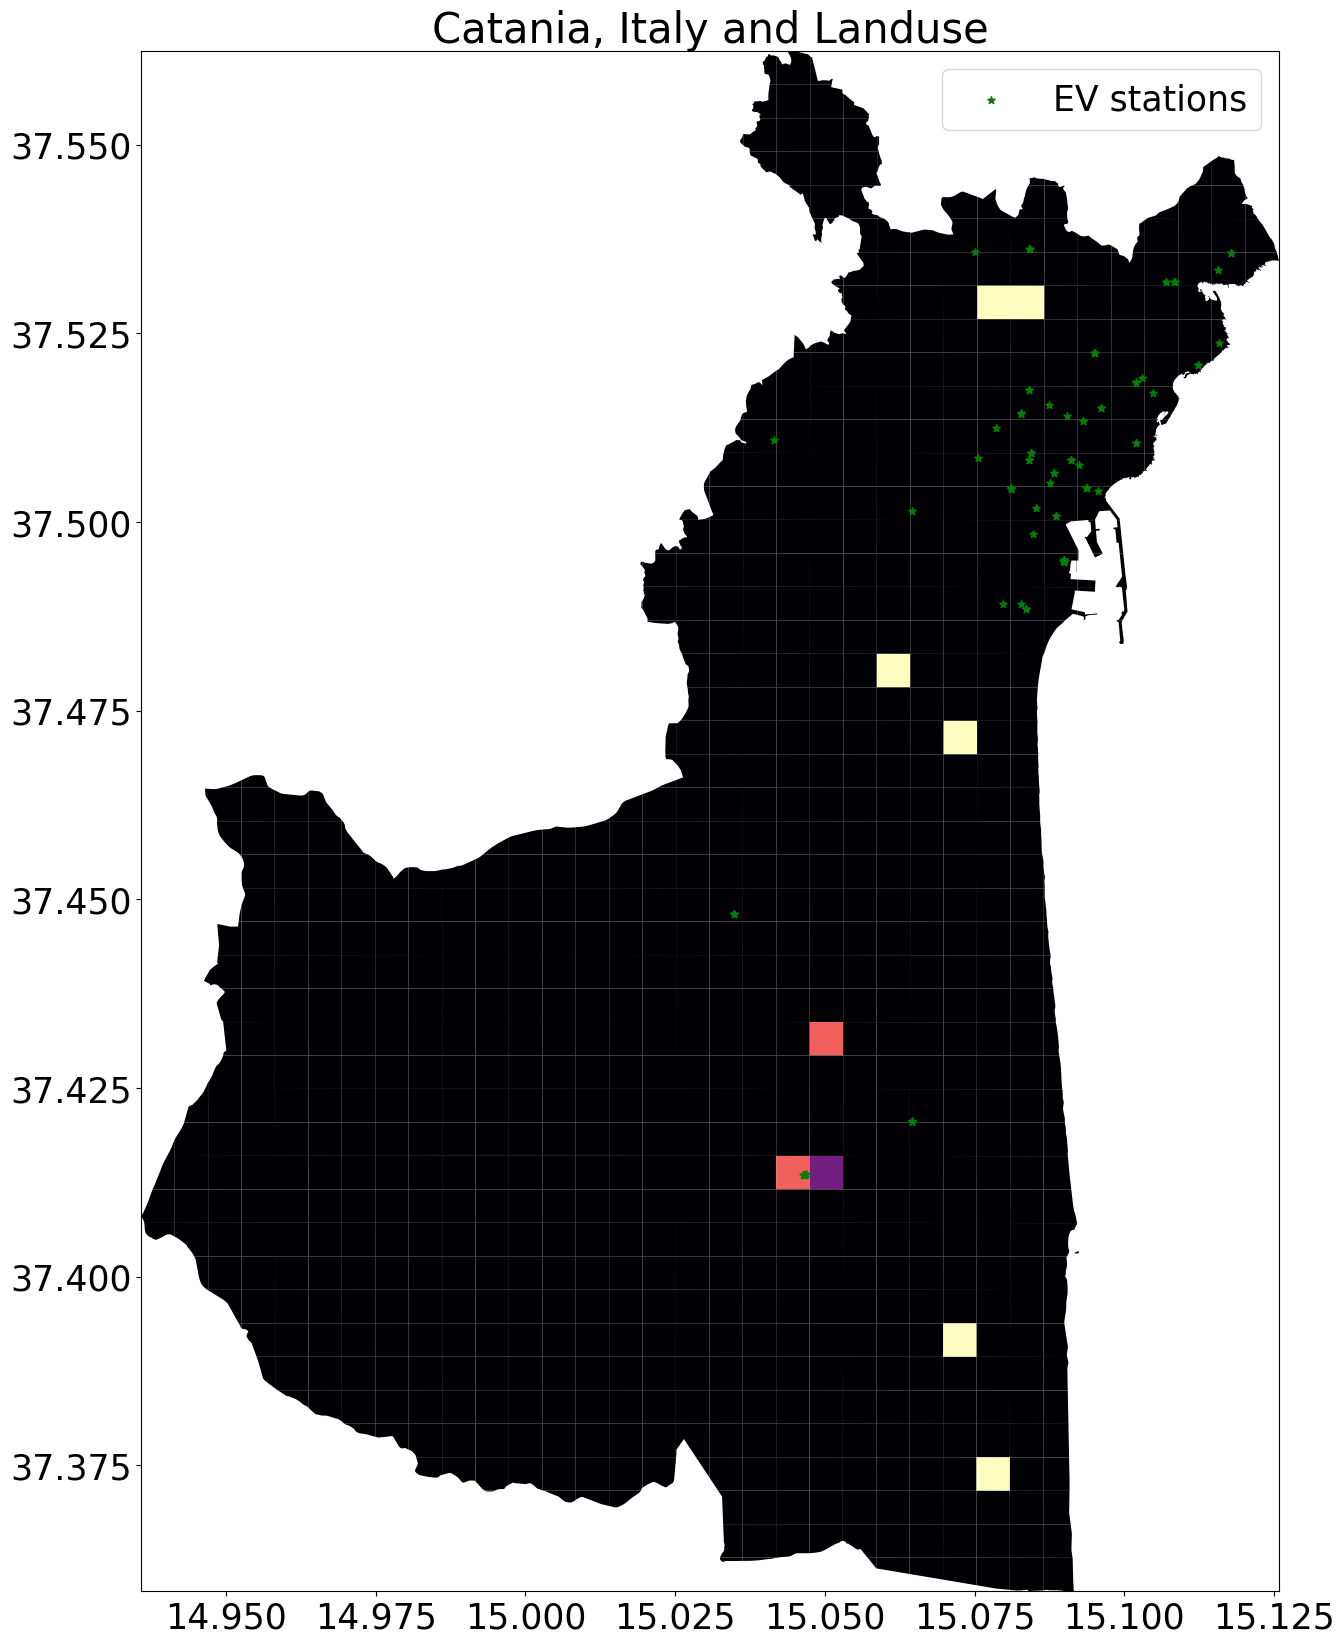

In [45]:
plt.rcParams.update({'font.size':25})
west, south, east, north = catania_polyframe_lat_long_new.unary_union.bounds

fig, ax = plt.subplots(figsize=(20,20))
catania_polyframe_lat_long_new.plot(ax=ax, column = 'landuse', legend=False, cmap='magma')
# add EV stations
EV_stations.plot(ax=ax, color='green', markersize=30, marker='*', label='EV stations')
ax.legend()
# add legend
plt.title(f'{PLACE_NAME} and Landuse')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
# ax.axis('off')30
plt.show()

In [46]:
catania_polyframe_lat_long_new.head()

geometry  EV_stations_counts  \
0  POLYGON ((14.93587 37.40803, 14.93611 37.40836...                   0   
1  POLYGON ((14.93775 37.41155, 14.93777 37.41159...                   0   
2  POLYGON ((14.94017 37.41598, 14.94038 37.41630...                   0   
3  POLYGON ((14.94145 37.40711, 14.94145 37.40529...                   0   
4  POLYGON ((14.94144 37.41816, 14.94156 37.41835...                   0   

  EV_stations_geomery  population landuse  
0                  []         0.0   Other  
1                  []         0.0   Other  
2                  []         0.0   Other  
3                  []         0.0   Other  
4                  []         0.0   Other

## Road Connectivity

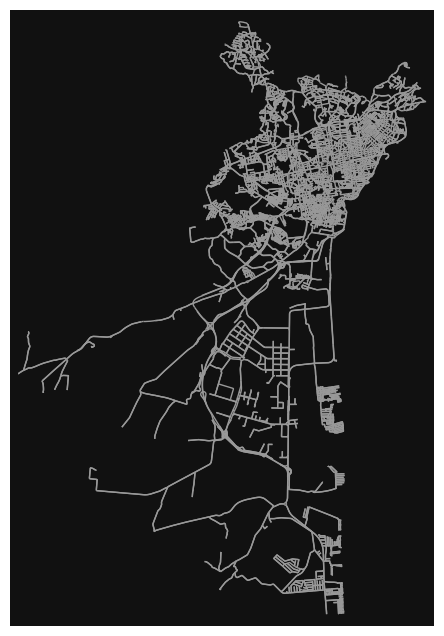

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [47]:
G = ox.graph_from_place(PLACE_NAME, network_type='drive')
ox.plot_graph(G, node_size= 0)

In [48]:
area,edges = ox.graph_to_gdfs(G)

In [49]:
#calculate number of edges and nodes for each grid
nodes = []
edges = []
density = []
for i in tqdm(range(0,city_polyframe_lat_long.shape[0])):
    try: 
        poly = city_polyframe_lat_long.loc[i, 'geometry']
        G = ox.graph_from_polygon(poly, network_type='drive')
        nodes.append(len(list(G.nodes())))
        edges.append(len(list(G.edges())))
        density.append(nx.density(G))
    except:
        nodes.append(0)
        edges.append(0)
        density.append(0)

100%|██████████| 872/872 [12:50<00:00,  1.13it/s]


In [50]:
#add nodes, edges and density to the dataframe
catania_polyframe_lat_long_new['nodes'] = nodes
catania_polyframe_lat_long_new['edges'] = edges
catania_polyframe_lat_long_new['density'] = density

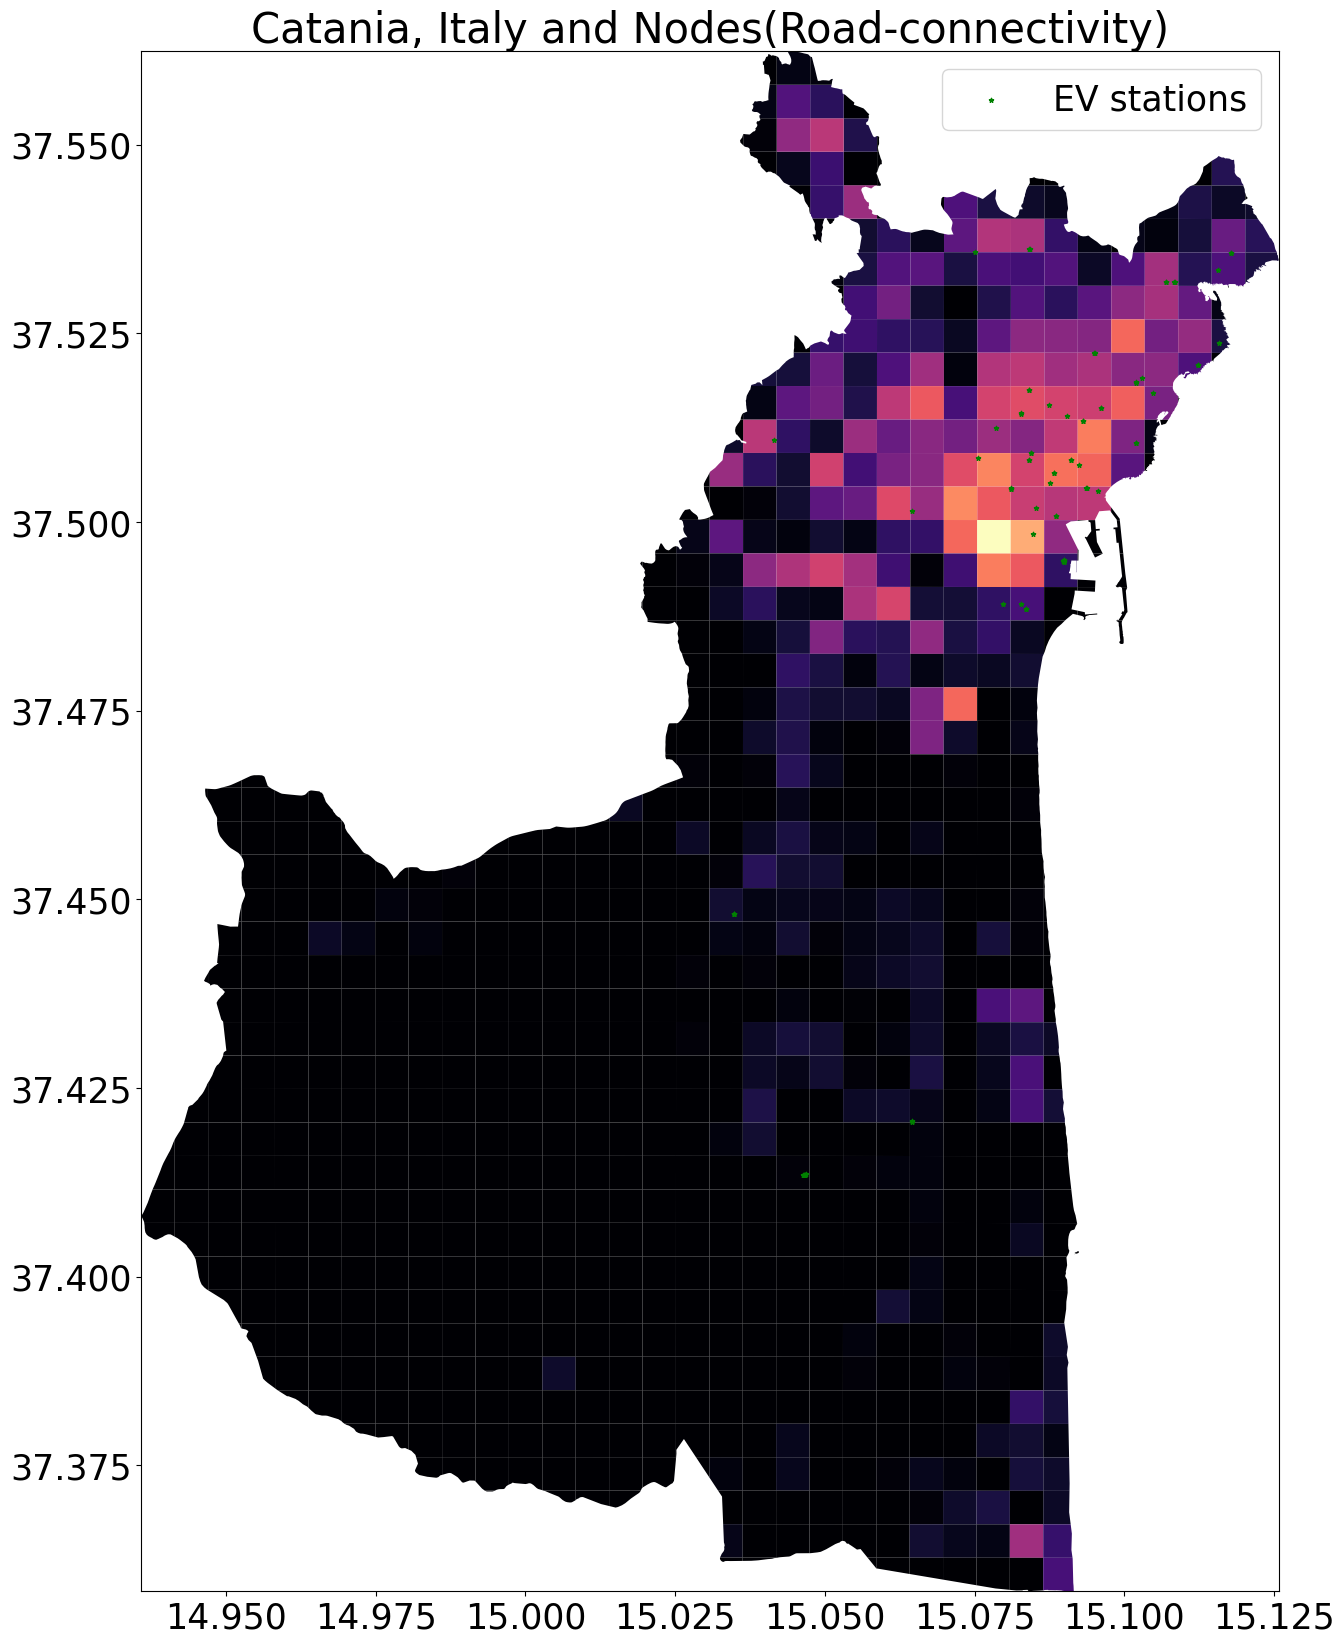

In [51]:
# relation between EVCSs and nodes
plt.rcParams.update({'font.size':25})
west, south, east, north = catania_polyframe_lat_long_new.unary_union.bounds

#nodes
fig, ax = plt.subplots(figsize=(20,20))
catania_polyframe_lat_long_new.plot(ax=ax, column = 'nodes', legend=False, cmap='magma')

# add EV stations
EV_stations.plot(ax=ax, color='green', markersize=10, marker='*', label='EV stations')

ax.legend()
plt.title(f'{PLACE_NAME} and Nodes(Road-connectivity)')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.show()

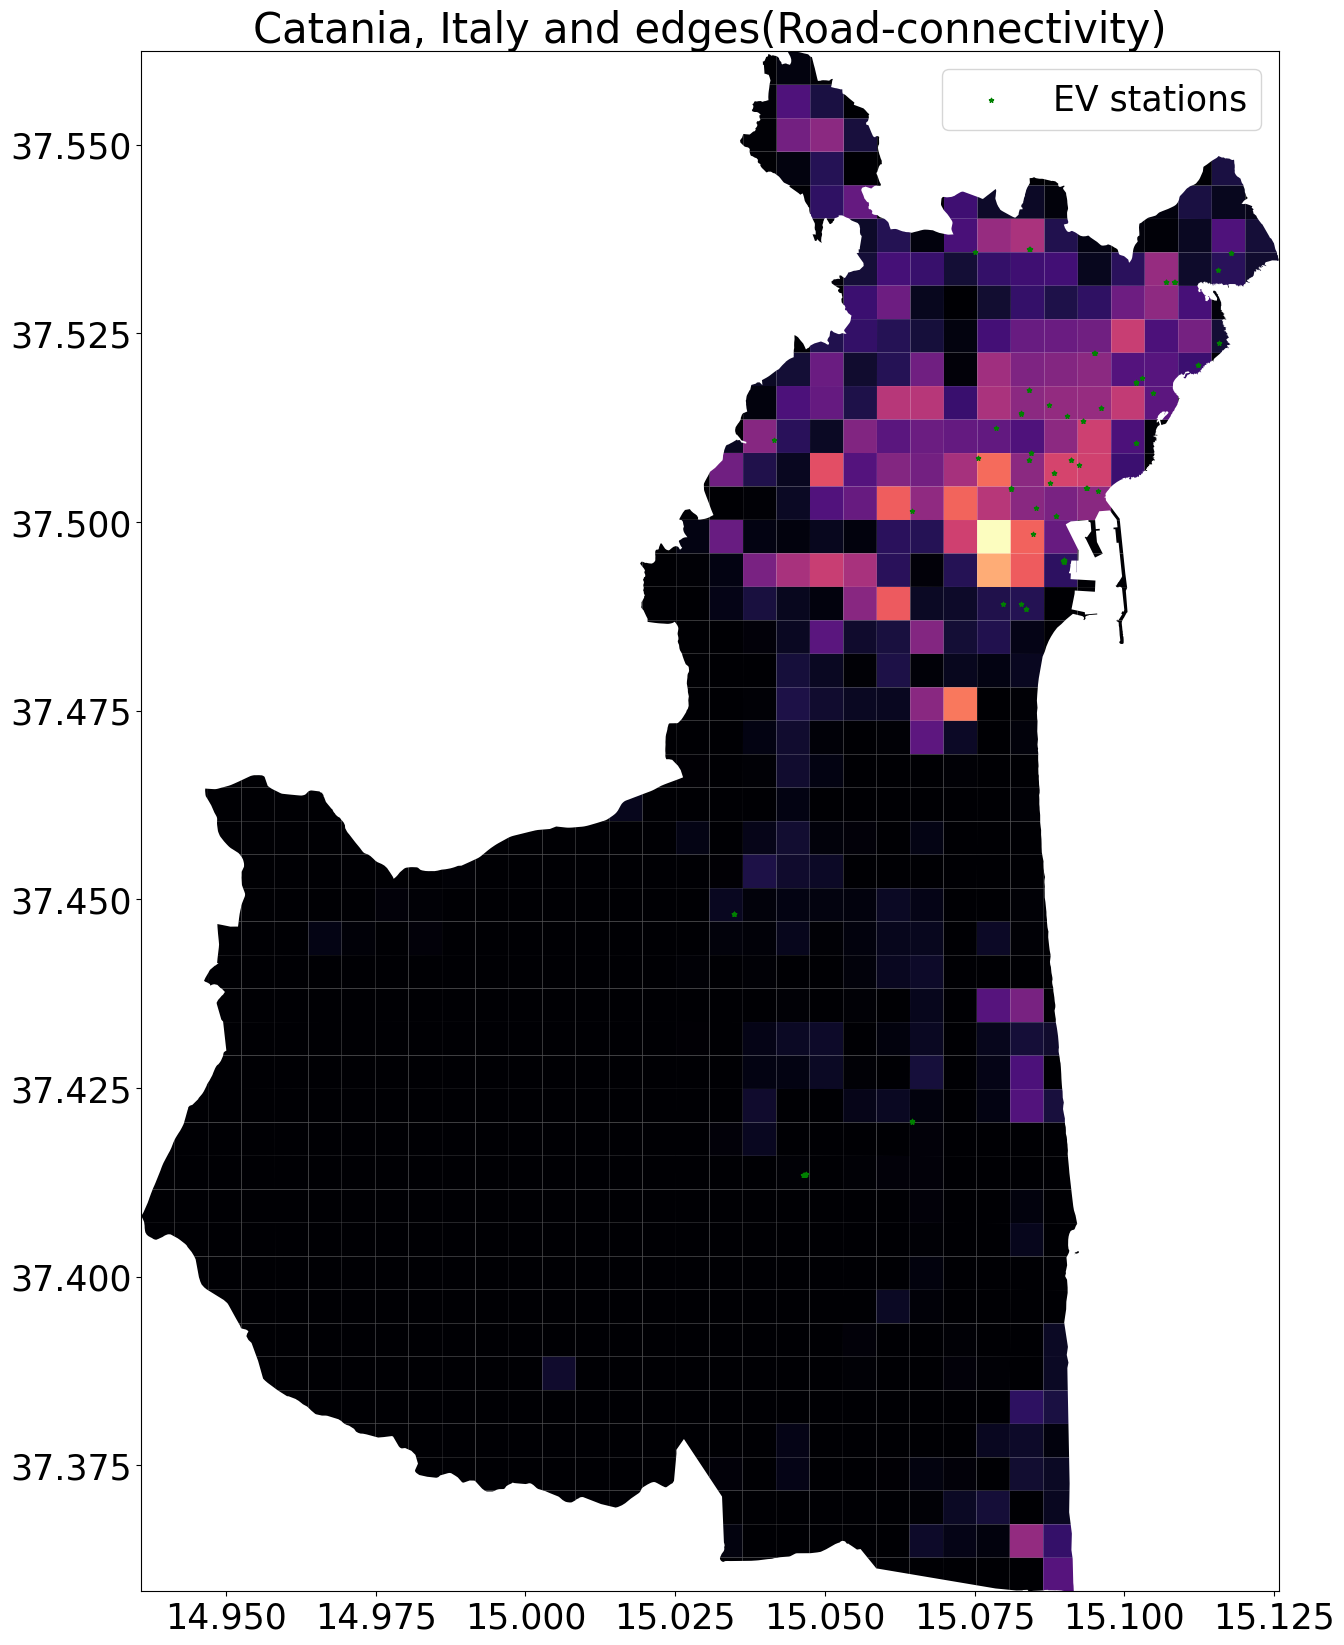

In [52]:
plt.rcParams.update({'font.size':25})
west, south, east, north = catania_polyframe_lat_long_new.unary_union.bounds

#edges
fig, ax = plt.subplots(figsize=(20,20))
catania_polyframe_lat_long_new.plot(ax=ax, column = 'edges', legend=False, cmap='magma')

# add EV stations
EV_stations.plot(ax=ax, color='green', markersize=10, marker='*', label='EV stations')

ax.legend()
plt.title(f'{PLACE_NAME} and edges(Road-connectivity)')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.show()

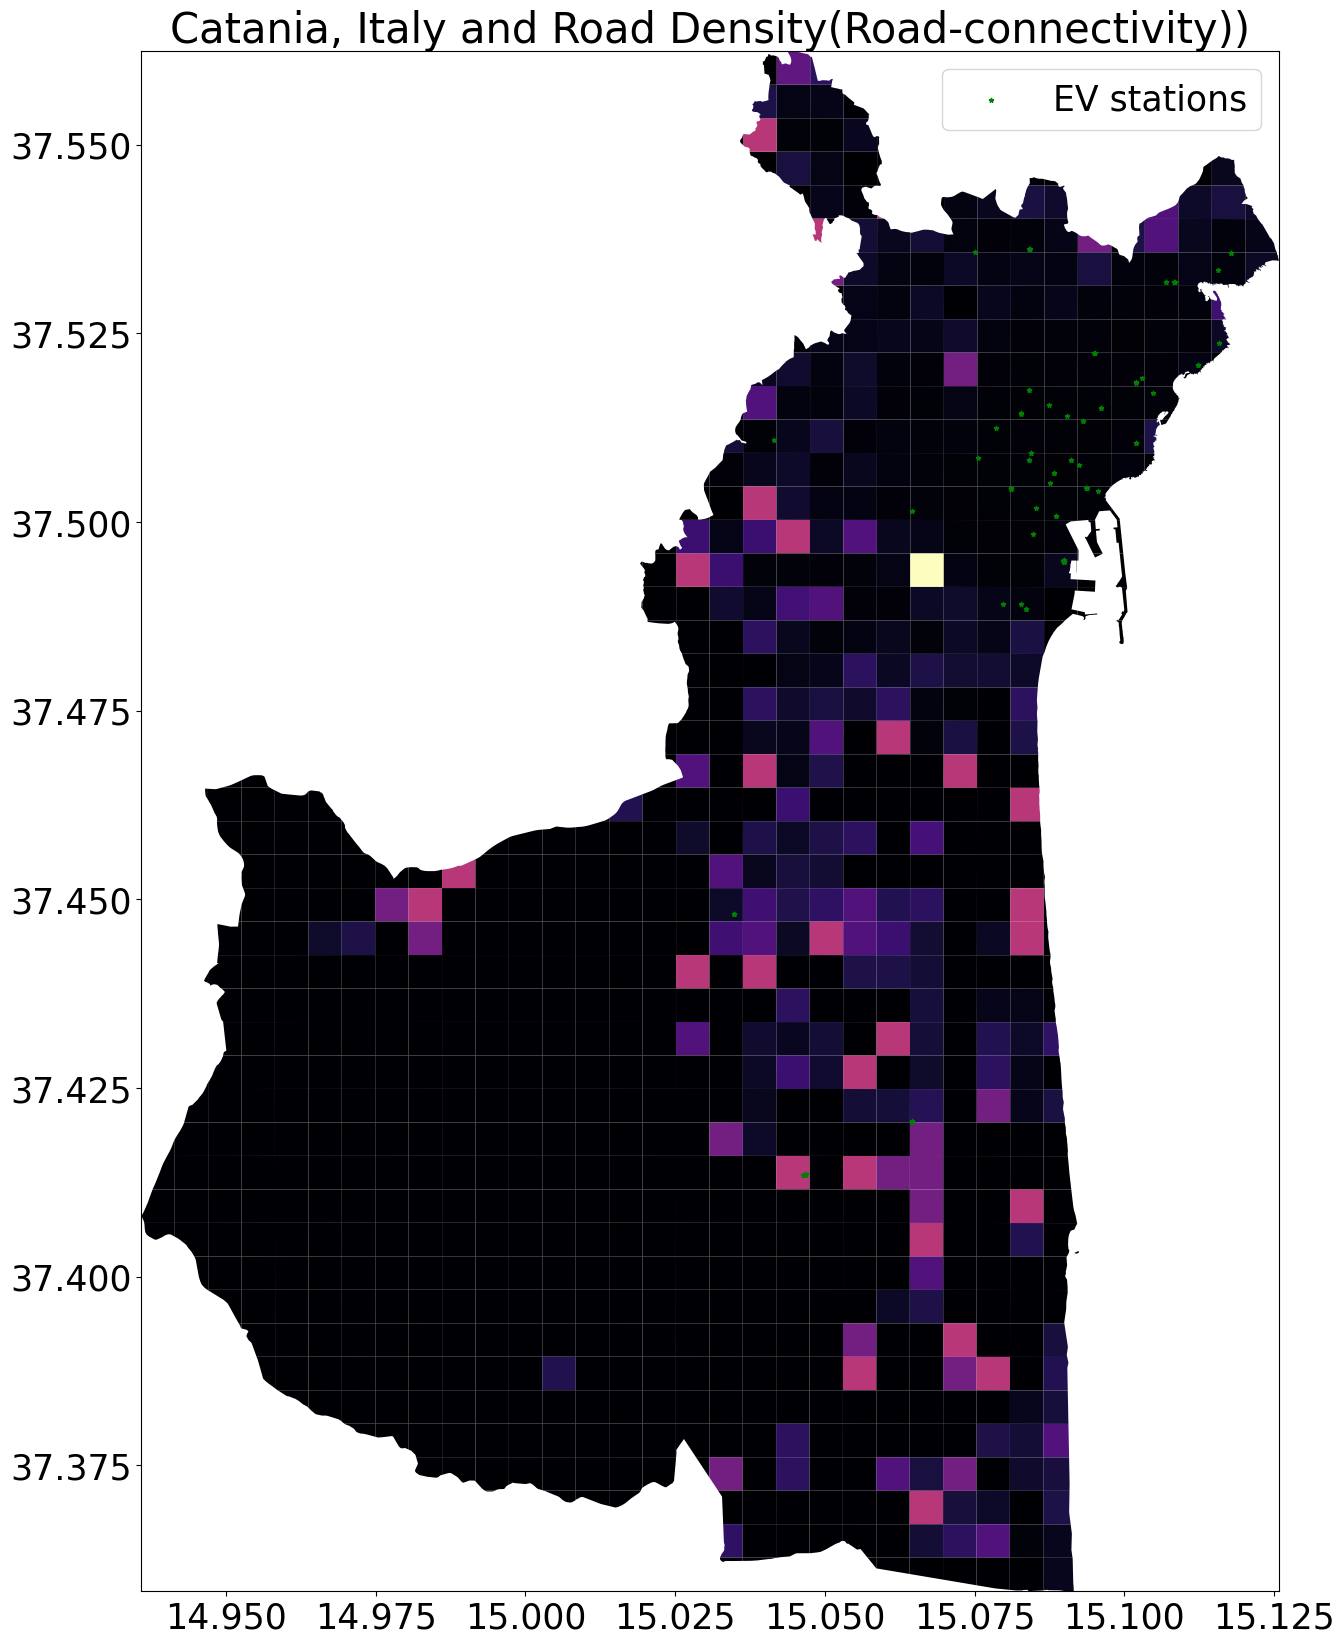

In [53]:
plt.rcParams.update({'font.size':25})
west, south, east, north = catania_polyframe_lat_long_new.unary_union.bounds

#density
fig, ax = plt.subplots(figsize=(20,20))
catania_polyframe_lat_long_new.plot(ax=ax, column = 'density', legend=False, cmap='magma')

# add EV stations
EV_stations.plot(ax=ax, color='green', markersize=10, marker='*', label='EV stations')

ax.legend()
plt.title(f'{PLACE_NAME} and Road Density(Road-connectivity))')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.show()

In [54]:
catania_polyframe_lat_long_new.head()

geometry  EV_stations_counts  \
0  POLYGON ((14.93587 37.40803, 14.93611 37.40836...                   0   
1  POLYGON ((14.93775 37.41155, 14.93777 37.41159...                   0   
2  POLYGON ((14.94017 37.41598, 14.94038 37.41630...                   0   
3  POLYGON ((14.94145 37.40711, 14.94145 37.40529...                   0   
4  POLYGON ((14.94144 37.41816, 14.94156 37.41835...                   0   

  EV_stations_geomery  population landuse  nodes  edges  density  
0                  []         0.0   Other      0      0      0.0  
1                  []         0.0   Other      0      0      0.0  
2                  []         0.0   Other      0      0      0.0  
3                  []         0.0   Other      0      0      0.0  
4                  []         0.0   Other      0      0      0.0

## POIs

In [55]:
import osmnx as ox
import pandas as pd
from tqdm import tqdm

def count_features_in_grids(place_name, features, city_polyframe, dataframe_name):
    for feature_key, feature_list in features.items():
        for feature in feature_list:
            try:
                # Fetch geometries from OpenStreetMap
                geometries = ox.geometries_from_place(
                    place_name,
                    {feature_key: feature}
                )
                # Export to CSV if geometries are found
                if not geometries.empty:
                    geometries.to_csv(f"D:/charging_stations/task2/dataset/Catania-{feature}.csv")

                    # Create masks for each grid
                    masks = []
                    for i in tqdm(range(0, city_polyframe.shape[0]), desc=f"Processing masks for {feature}"):
                        pip_mask = geometries.within(city_polyframe.loc[i, 'geometry'])
                        masks.append(pip_mask)

                    # Count features in each grid
                    feature_counts = []
                    for i in tqdm(range(0, city_polyframe.shape[0]), desc=f"Counting {feature}"):
                        feature_counts.append(geometries[masks[i]].shape[0])

                    # Add counts to the dataframe
                    dataframe_name[f'{feature}_count'] = feature_counts
                else:
                    print(f"No data found for {feature_key}='{feature}' in {place_name}.")
            except Exception as e:
                print(f"Failed to process {feature_key}='{feature}' in {place_name}: {str(e)}")

In [56]:
features = {
    'amenity': ['school', 'university', 'restaurant', 'place_of_worship', 
                'community_centre', 'townhall', 'parking', 'library'],
    'leisure': ['park', 'cinema'],
    'building': ['commercial', 'government', 'civic', 'retail']
}

city_polyframe = catania_polyframe_lat_long_new

count_features_in_grids(PLACE_NAME, features, city_polyframe, catania_polyframe_lat_long_new)

/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='school' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='university' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='restaurant' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='place_of_worship' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='community_centre' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='townhall' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='parking' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process amenity='library' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process leisure='park' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process leisure='cinema' in Catania, Italy: No data elements in server response. Check log and query location/tags.


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process building='commercial' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process building='government' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process building='civic' in Catania, Italy: No data elements in server response. Check log and query location/tags.


/var/folders/nh/9d8r8prn3819gz07wlp9htdw0000gn/T/ipykernel_92835/2959745981.py:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  geometries = ox.geometries_from_place(


Failed to process building='retail' in Catania, Italy: Cannot save file into a non-existent directory: 'D:/charging_stations/task2/dataset'


In [57]:
catania_polyframe_lat_long_new.head().T

0  \
geometry             POLYGON ((14.9358674 37.408029500000005, 14.93...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   

                                                                     1  \
geometry             POLYGON ((14.937751629594667 37.41154698845851...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   

                                                                     2  \
geometry             POLYGON ((14.940171212199463 37.41598449515197...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   

                                                                     3  \
geometry             POLYGON ((14.941447949208818 37.40711261590081...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   

                                                                     4  
geometry             POLYGON ((14.941439351952146 37.41815701905266...  
EV_stations_counts                                                   0  
EV_stations_geomery                                                 []  
population                                                         0.0  
landuse                                                          Other  
nodes                                                                0  
edges                                                                0  
density                                                            0.0

## Traffic

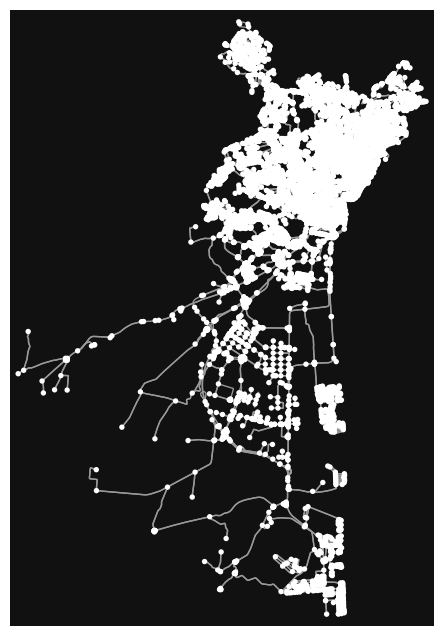

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [58]:
# Fetch road network data
catania_graph = ox.graph_from_place(PLACE_NAME, network_type='drive')

# Visualize the road network
ox.plot_graph(catania_graph)

In [59]:
# Convert the graph to edge GeoDataFrame
edges = ox.graph_to_gdfs(catania_graph, nodes=False, edges=True)

In [60]:
selected_columns = edges[['osmid', 'oneway', 'lanes', 'highway', 'maxspeed', 
                          'geometry']]

In [61]:
selected_columns.head()

osmid  oneway lanes       highway maxspeed  \
u         v          key                                                   
252159891 277025894  0     23497741    True   NaN     secondary      NaN   
          295445631  0    177034799   False   NaN     secondary      NaN   
253928007 4110557214 0    655697295    True   NaN  unclassified      NaN   
          837073784  0     70077840    True   NaN  unclassified      NaN   
          837074176  0    179447881   False   NaN  unclassified       20   

                                                                   geometry  
u         v          key                                                     
252159891 277025894  0    LINESTRING (15.08331 37.50490, 15.08324 37.504...  
          295445631  0    LINESTRING (15.08331 37.50490, 15.08331 37.504...  
253928007 4110557214 0    LINESTRING (15.06604 37.47248, 15.06601 37.47234)  
          837073784  0    LINESTRING (15.06604 37.47248, 15.06604 37.472...  
          837074176  0    LINESTRING (15.06604 37.47248, 15.06604 37.472...

In [62]:
# Drop rows where any cell in that row is NA
selected_columns = selected_columns.dropna()

In [63]:
# Convert road network to a projected CRS
road_network = selected_columns.to_crs(epsg=32633)

# Also ensure your polygons are in the same CRS
catania_polyframe_lat_long_new = catania_polyframe_lat_long_new.to_crs(epsg=32633)

In [64]:
# Calculate centroids safely
road_centers = road_network.centroid

In [65]:
def check_one_way(polygon, roads):
    # Recalculate centroids here if necessary
    road_centers = roads.centroid  # Ensure 'roads' is already in a projected CRS
    within_mask = road_centers.within(polygon)
    one_way_roads = roads[within_mask & roads['oneway']]
    return 'Yes' if not one_way_roads.empty else 'No'

# Apply the function
catania_polyframe_lat_long_new['oneway_exists'] = catania_polyframe_lat_long_new['geometry'].apply(check_one_way, roads=road_network)

In [66]:
catania_polyframe_lat_long_new.head().T

0  \
geometry             POLYGON ((494324.36910769687 4140139.900782528...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   

                                                                     1  \
geometry             POLYGON ((494491.37794651155 4140530.022613017...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   

                                                                     2  \
geometry             POLYGON ((494705.80941380473 4141022.185615587...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   

                                                                     3  \
geometry             POLYGON ((494818.1755447965 4140037.859610446,...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   

                                                                     4  
geometry             POLYGON ((494818.17554479634 4141263.137357092...  
EV_stations_counts                                                   0  
EV_stations_geomery                                                 []  
population                                                         0.0  
landuse                                                          Other  
nodes                                                                0  
edges                                                                0  
density                                                            0.0  
oneway_exists                                                       No

In [67]:
def check_highways(polygon, roads):
    # Calculate centroids for the roads and check if they fall within the given polygon
    road_centers = roads.centroid
    within_mask = road_centers.within(polygon)
    highways_within = roads.loc[within_mask, 'highway']

    # Flatten the list of highways if they are stored in lists within cells
    flattened_highways = []
    for item in highways_within.dropna():
        if isinstance(item, list):
            flattened_highways.extend(item)  # Extend the flat list with elements of the sublist
        else:
            flattened_highways.append(item)  # Append the item directly if it's not a list

    # Create a set of unique highway types, removing duplicates and handling unhashable types
    unique_highways = set(flattened_highways)
    return unique_highways if unique_highways else 'None'

In [68]:
catania_polyframe_lat_long_new['highway_types'] = catania_polyframe_lat_long_new['geometry'].apply(check_highways, roads=road_network)

In [69]:
catania_polyframe_lat_long_new.head().T

0  \
geometry             POLYGON ((494324.36910769687 4140139.900782528...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   

                                                                     1  \
geometry             POLYGON ((494491.37794651155 4140530.022613017...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   

                                                                     2  \
geometry             POLYGON ((494705.80941380473 4141022.185615587...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   

                                                                     3  \
geometry             POLYGON ((494818.1755447965 4140037.859610446,...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   

                                                                     4  
geometry             POLYGON ((494818.17554479634 4141263.137357092...  
EV_stations_counts                                                   0  
EV_stations_geomery                                                 []  
population                                                         0.0  
landuse                                                          Other  
nodes                                                                0  
edges                                                                0  
density                                                            0.0  
oneway_exists                                                       No  
highway_types                                                     None

In [70]:
def aggregate_lanes(polygon, roads):
    road_centers = roads.centroid
    within_mask = road_centers.within(polygon)
    lanes_within = roads.loc[within_mask, 'lanes'].dropna()
    # Convert data to numeric, because 'lanes' might be stored as strings
    lanes_within = pd.to_numeric(lanes_within, errors='coerce')
    return lanes_within.mean()  # You could also consider sum, max, or other aggregations

In [71]:
catania_polyframe_lat_long_new['average_lanes'] = catania_polyframe_lat_long_new['geometry'].apply(aggregate_lanes, roads=road_network)

In [72]:
def aggregate_maxspeed(polygon, roads):
    road_centers = roads.centroid
    within_mask = road_centers.within(polygon)
    maxspeed_within = roads.loc[within_mask, 'maxspeed'].dropna()
    
    # Process each maxspeed entry, whether list or string, to get numeric values
    def process_maxspeed_entry(entry):
        if isinstance(entry, list):
            # Assuming the list has a string with the first element as the speed
            return pd.to_numeric(entry[0].split(' ')[0], errors='coerce')
        elif isinstance(entry, str):
            return pd.to_numeric(entry.split(' ')[0], errors='coerce')
        else:
            return pd.NA  # Pandas' NA for missing type-aware handling

    # Apply processing function to each item in the series
    maxspeed_numeric = maxspeed_within.apply(process_maxspeed_entry)
    return maxspeed_numeric.mean()  # Calculate mean of the cleaned, numeric maxspeed values

In [73]:
catania_polyframe_lat_long_new['average_maxspeed'] = catania_polyframe_lat_long_new['geometry'].apply(aggregate_maxspeed, roads=road_network)

In [74]:
catania_polyframe_lat_long_new['city'] = 'Catania'

In [75]:
catania_polyframe_lat_long_new.head().T

0  \
geometry             POLYGON ((494324.36910769687 4140139.900782528...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   
average_lanes                                                      NaN   
average_maxspeed                                                   NaN   
city                                                           Catania   

                                                                     1  \
geometry             POLYGON ((494491.37794651155 4140530.022613017...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   
average_lanes                                                      NaN   
average_maxspeed                                                   NaN   
city                                                           Catania   

                                                                     2  \
geometry             POLYGON ((494705.80941380473 4141022.185615587...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   
average_lanes                                                      NaN   
average_maxspeed                                                   NaN   
city                                                           Catania   

                                                                     3  \
geometry             POLYGON ((494818.1755447965 4140037.859610446,...   
EV_stations_counts                                                   0   
EV_stations_geomery                                                 []   
population                                                         0.0   
landuse                                                          Other   
nodes                                                                0   
edges                                                                0   
density                                                            0.0   
oneway_exists                                                       No   
highway_types                                                     None   
average_lanes                                                      NaN   
average_maxspeed                                                   NaN

In [76]:
# Save the updated DataFrame to a CSV file
catania_polyframe_lat_long_new.to_csv(r"D:\BIG_DATA\charging_stations\task_2\catania.csv", index=False)